## 1 读取数据

In [94]:
import gc
import time
from datetime import date
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)

In [95]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [112]:
df = pd.read_csv('./input/bank-additional-train.csv')
df['y'].replace(['no','yes'],[0,1],inplace=True)

In [113]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,management,married,professional.course,unknown,no,no,cellular,jul,mon,565,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
1,41,admin.,married,high.school,no,yes,yes,cellular,apr,mon,982,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
2,32,admin.,married,university.degree,no,yes,no,cellular,may,mon,188,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,0
3,37,admin.,married,high.school,no,unknown,unknown,cellular,jul,thu,56,3,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
4,38,admin.,divorced,university.degree,no,no,no,cellular,jul,tue,419,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0


```text
Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   # related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   # other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
   # social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

```

In [114]:
# nan值统计
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

可以看到数据的每一列都没有空值，这就很完美了，我们不需要处理空值了

In [115]:
# 数据特征简单统计描述
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000
mean,40.043783,258.374868,2.573552,962.543419,0.172570,0.082759,93.575098,-40.502147,3.622370,5167.150813,0.112250
std,10.395798,260.203020,2.786845,186.740644,0.494031,1.571270,0.579297,4.630409,1.733892,72.168914,0.315678
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


## 2 数据探索

In [146]:
profile = pdp.ProfileReport(df, check_correlation=False)
profile.to_file(outputfile="output_df_train.html")
profile

Number of variables,22
Number of observations,37069
Total Missing (%),0.0%
Total size in memory,6.2 MiB
Average record size in memory,176.0 B
Numeric,10
Categorical,10
Boolean,2
Date,0
Text (Unique),0
Rejected,0


In [117]:
df['y_']=1-df['y']

### 2.1 age vs y
根据年龄来看客户是否购买了定期存款？

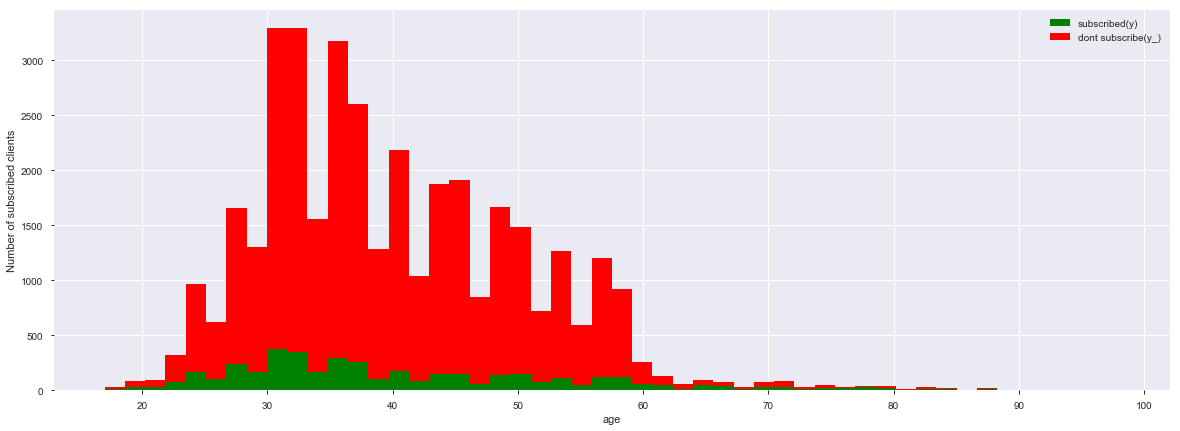

In [118]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['age'], df[df['y'] == 0]['age']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('age')
plt.ylabel('Number of subscribed clients')
plt.legend();

### 2.2 job vs y
看看客户的工作是否对订购套餐有影响

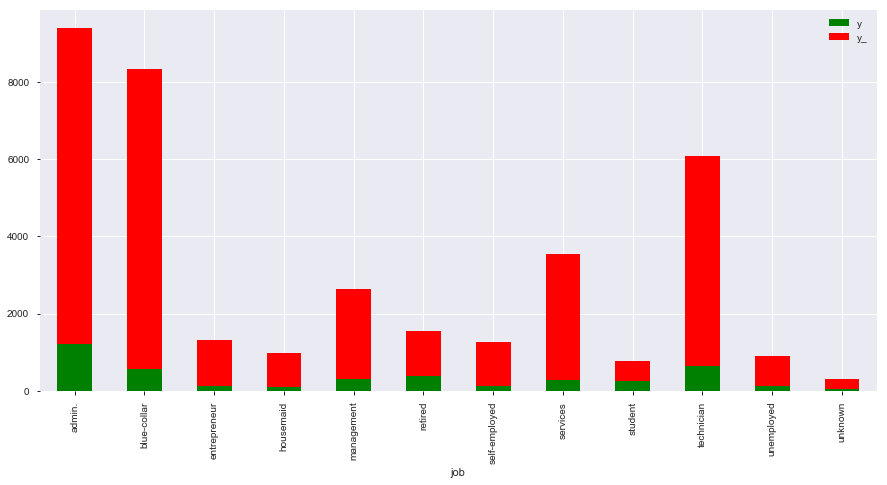

In [125]:
df.groupby('job').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

从上图中可以看到，从事admin、technician的客户订购存款的比较多，其次是blue-collar和management

### 2.3 marital vs y
婚姻状况对订购存款的影响

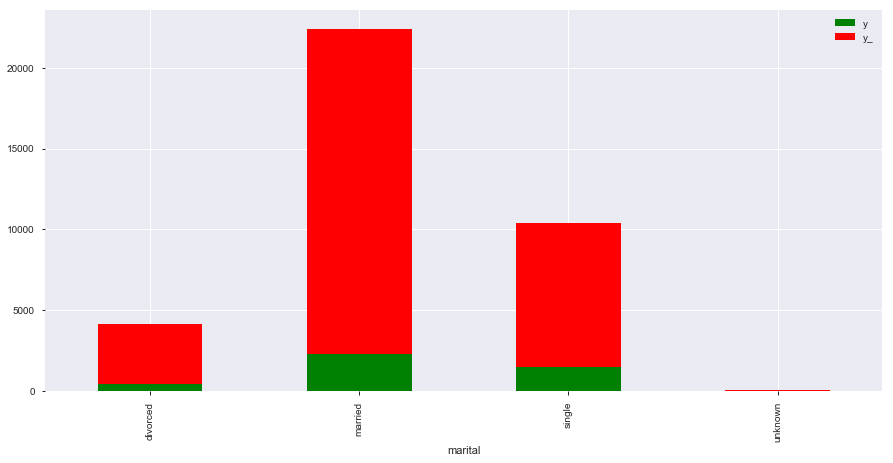

In [127]:
df.groupby('marital').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

离婚和婚姻状况不明的购买存款的很少

### 2.4 education vs y

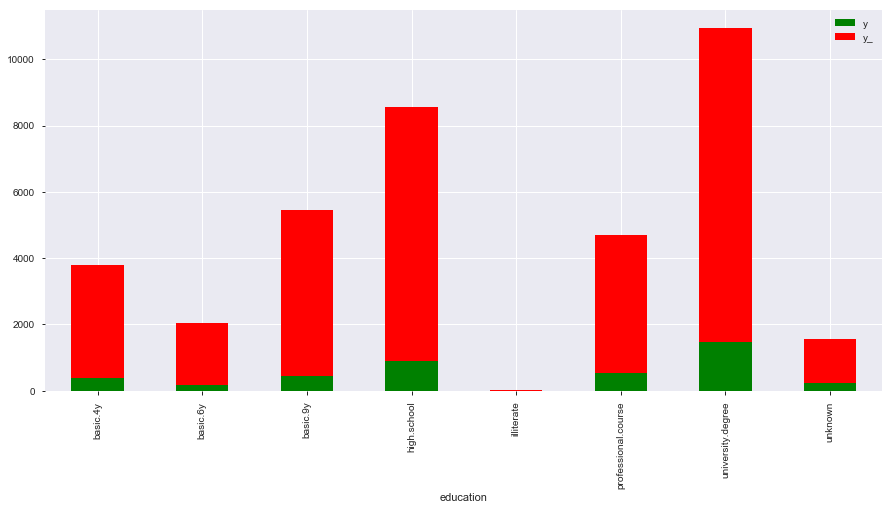

In [128]:
df.groupby('education').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

我们发现教育水平较高的，比如大学，高中及以上的，购买存款的比较多

### 2.5 default vs y

has credit in default?

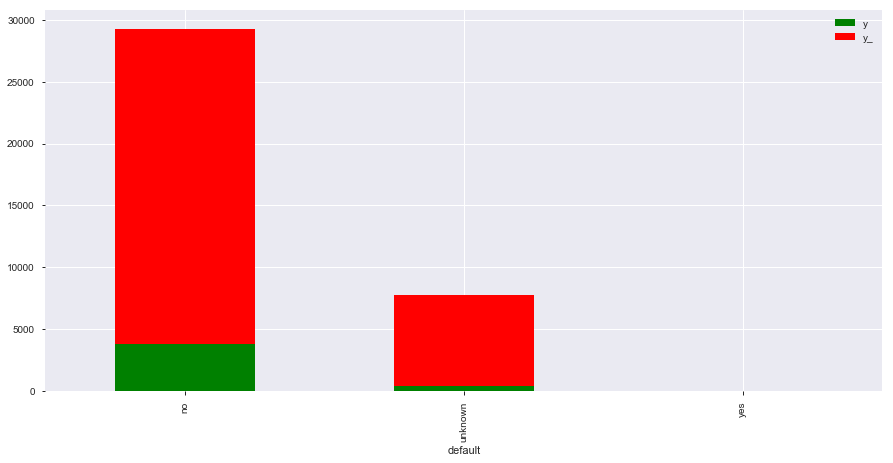

In [130]:
df.groupby('default').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

### 2.6 housing vs y

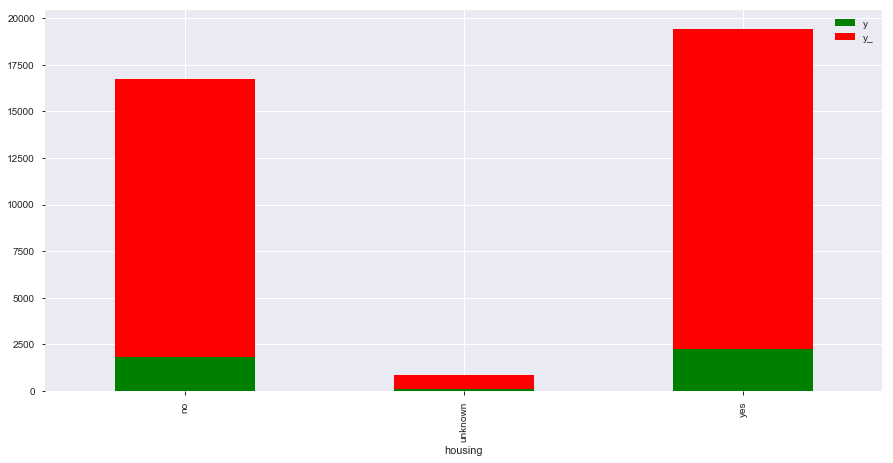

In [131]:
df.groupby('housing').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

从上图可以发现，有无房屋贷款影响不是很大，购买存款比例相当

### 2.7 loan vs y

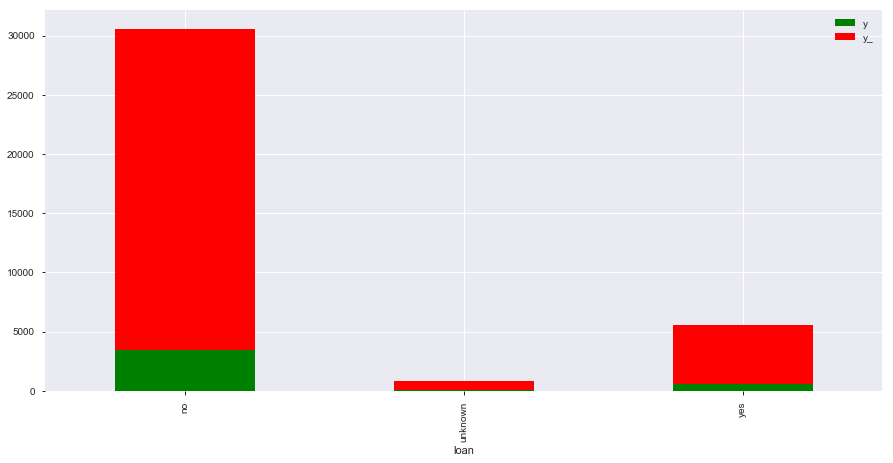

In [132]:
df.groupby('loan').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

没有个人贷款的客户更倾向于购买贷款,可能有个人贷款的本身经济压力大

### 2.8 contact vs y

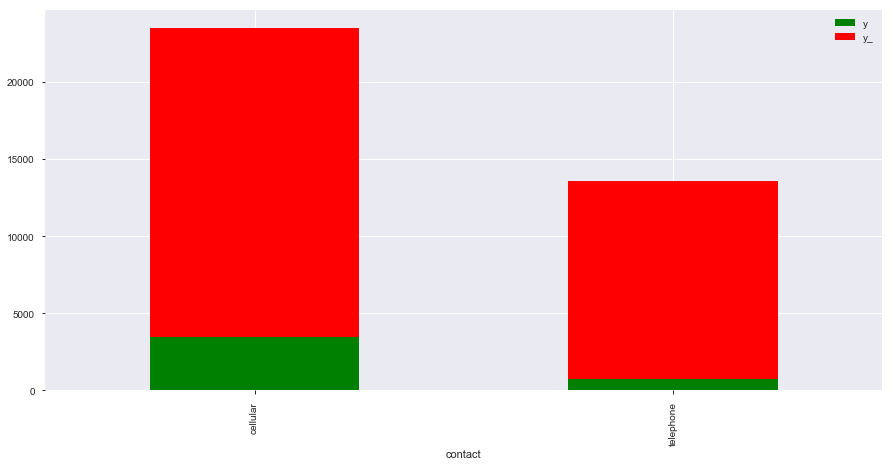

In [133]:
df.groupby('contact').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

看来拥有手机的客户更有能力买存款，是不是因为他们富裕一些

### 2.9 campaign vs y

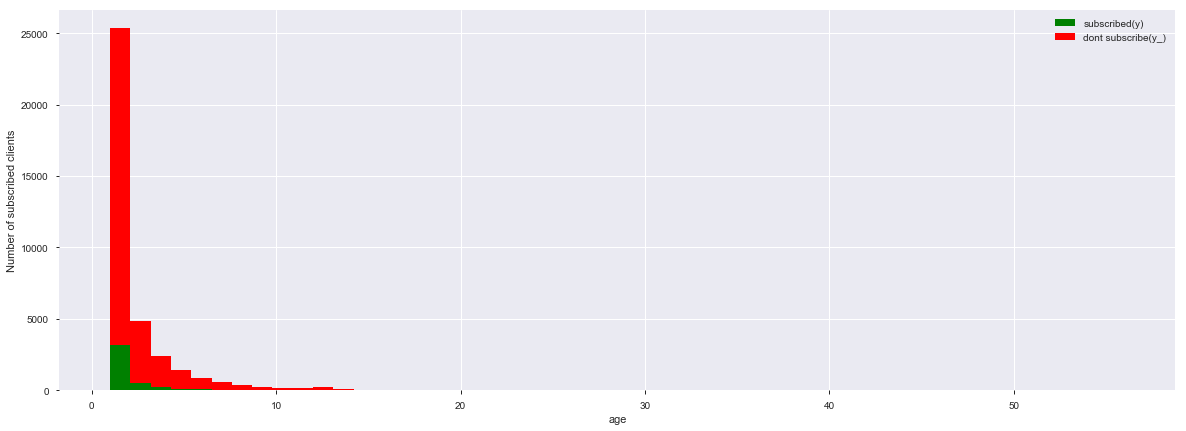

In [136]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['campaign'], df[df['y'] == 0]['campaign']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('age')
plt.ylabel('Number of subscribed clients')
plt.legend();

上图看不出联系次数是否对购买存款有影响，联系次数少存在大量不购买的情况，同时购买也集中在这一部分

### 2.10 pdays vs y

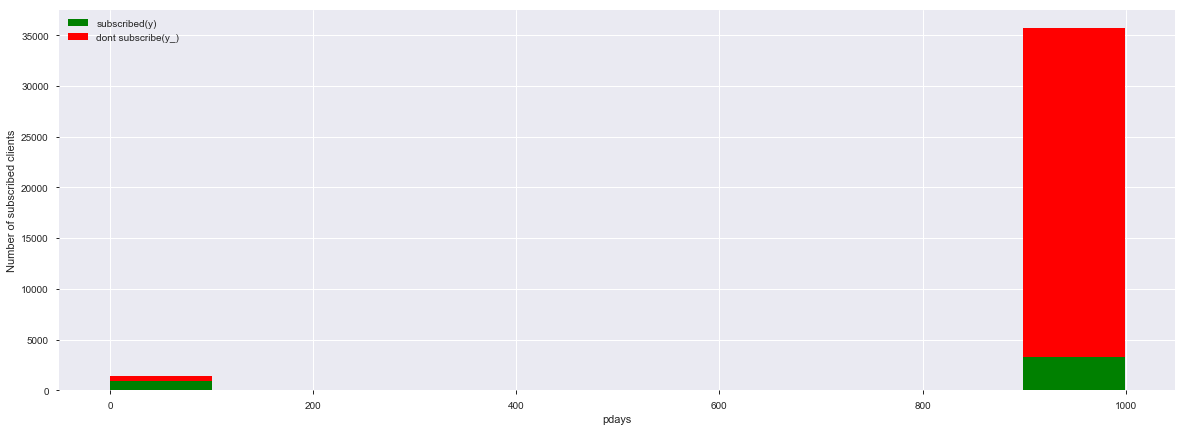

In [145]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['pdays'], df[df['y'] == 0]['pdays']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('pdays')
plt.ylabel('Number of subscribed clients')
plt.legend();

pdays有96.3%的值有999，也就是数据缺失不知道，这个也看不出来有太大影响

### 2.11 previous vs y

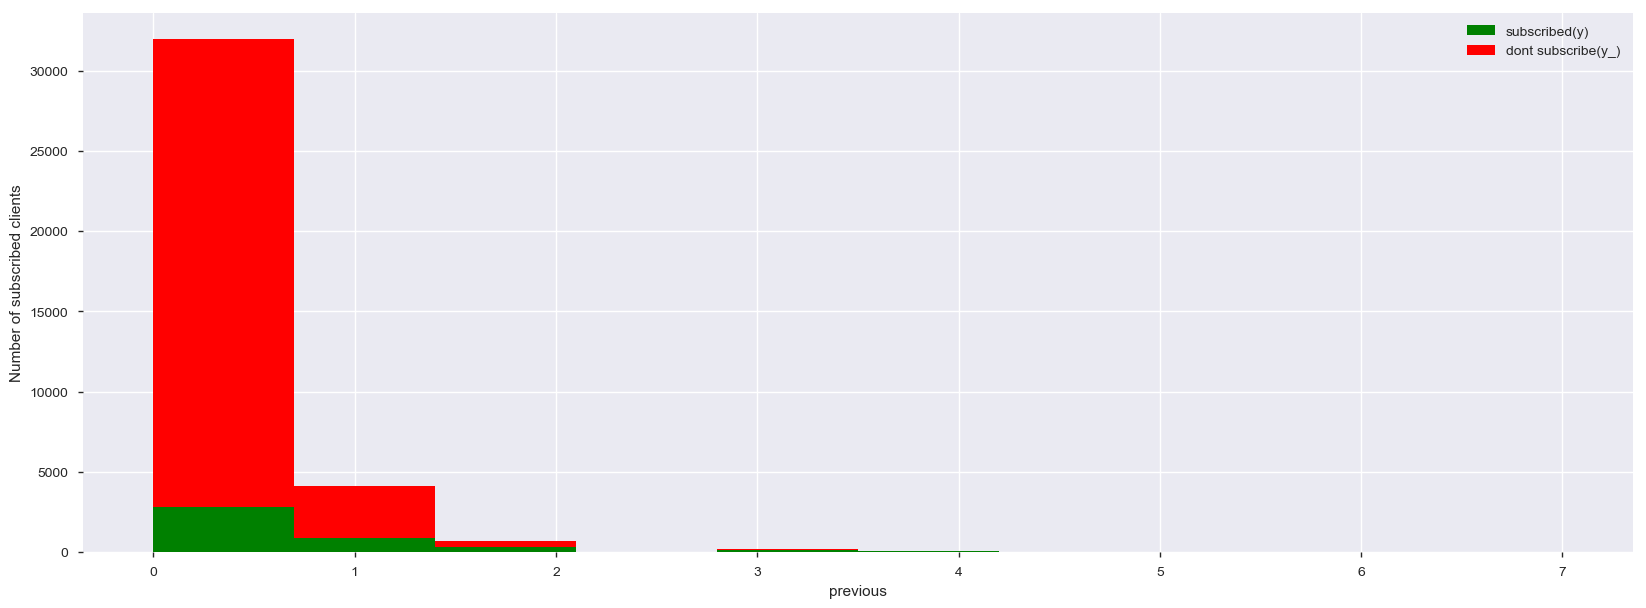

In [147]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['previous'], df[df['y'] == 0]['previous']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('previous')
plt.ylabel('Number of subscribed clients')
plt.legend();

在活动之前是否联系客户似乎看起来影响也不是很大

### 2.11 poutcome vs y

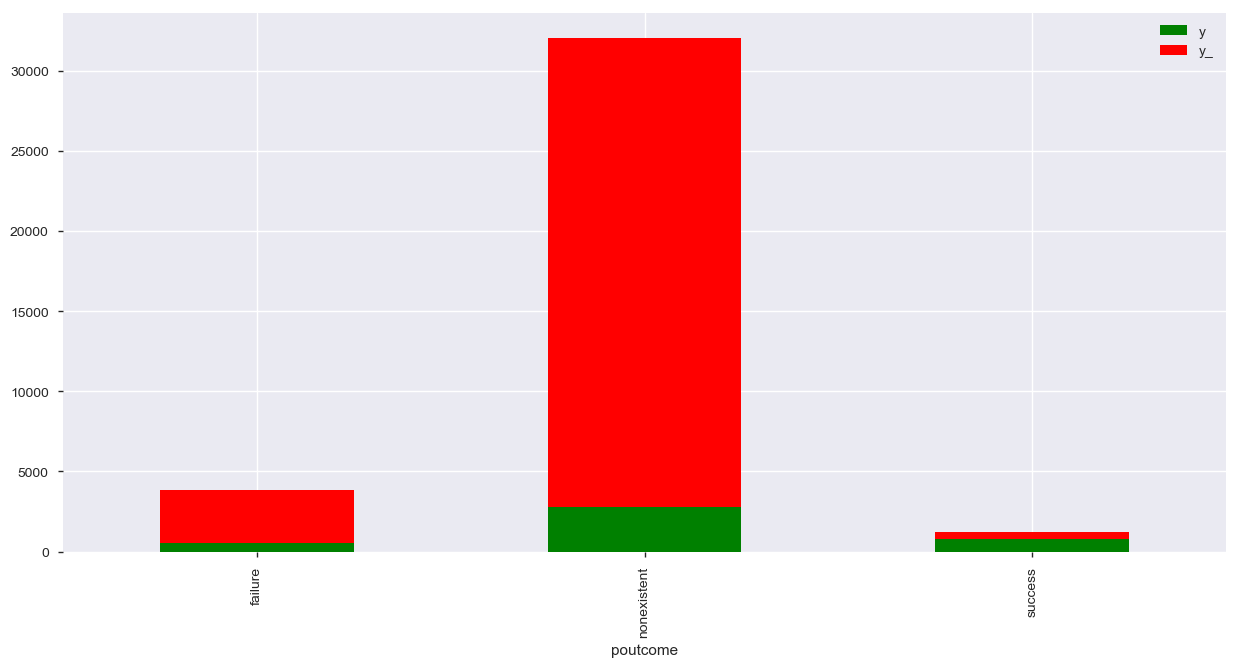

In [149]:
df.groupby('poutcome').agg('sum')[['y', 'y_']].plot(kind='bar', figsize=(15, 7),
                                                          stacked=True, color=['g', 'r']);

上次活动是否成功，我们发现参加活动上次购买的，基本下次也会购买

### 2.12 employment variation rate vs y

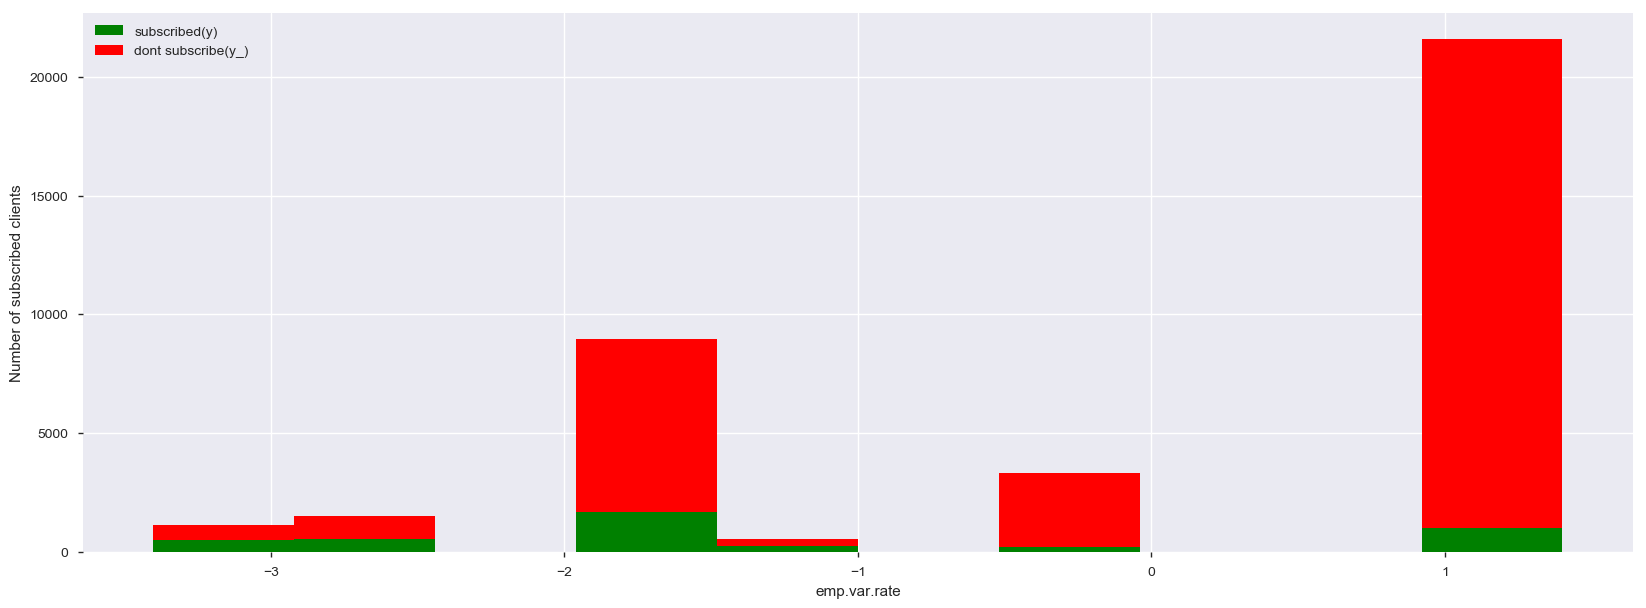

In [150]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['emp.var.rate'], df[df['y'] == 0]['emp.var.rate']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('emp.var.rate')
plt.ylabel('Number of subscribed clients')
plt.legend();

### 2.13 consumer price index

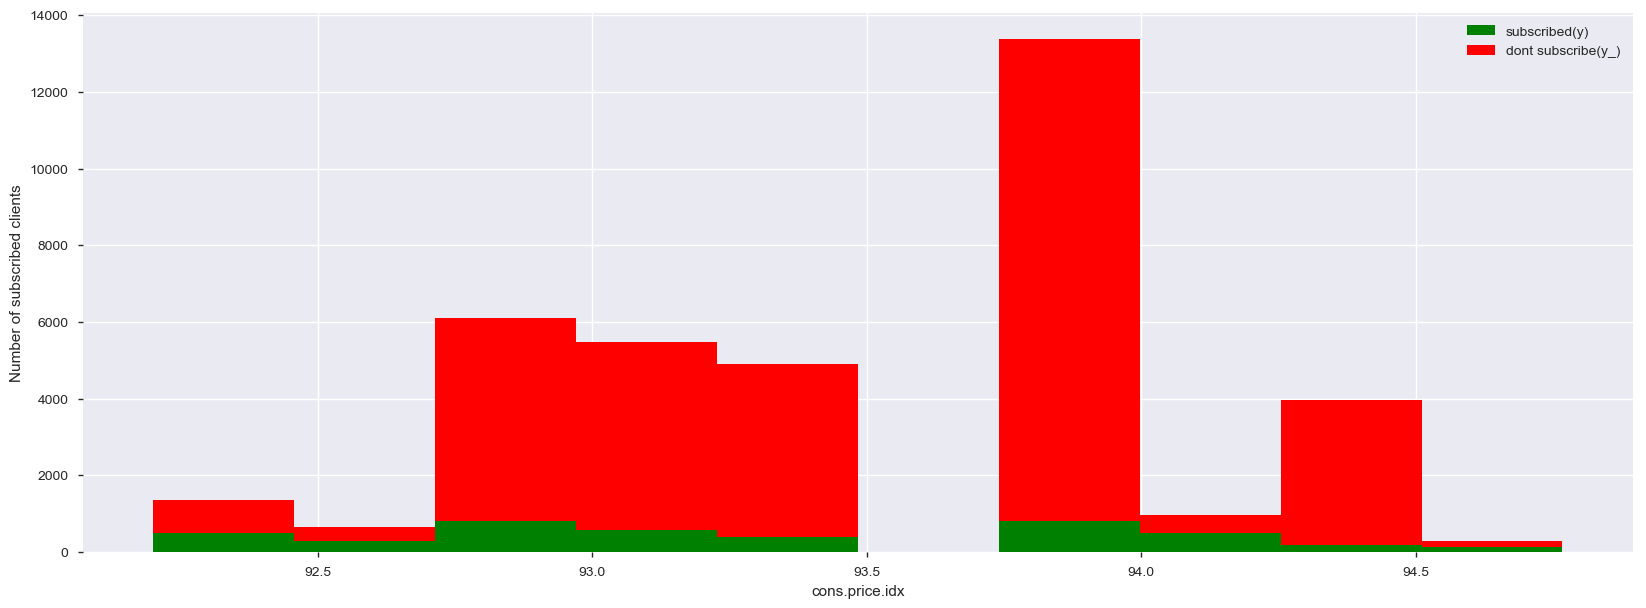

In [151]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['cons.price.idx'], df[df['y'] == 0]['cons.price.idx']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('cons.price.idx')
plt.ylabel('Number of subscribed clients')
plt.legend();

### 2.14 consumer confidence index

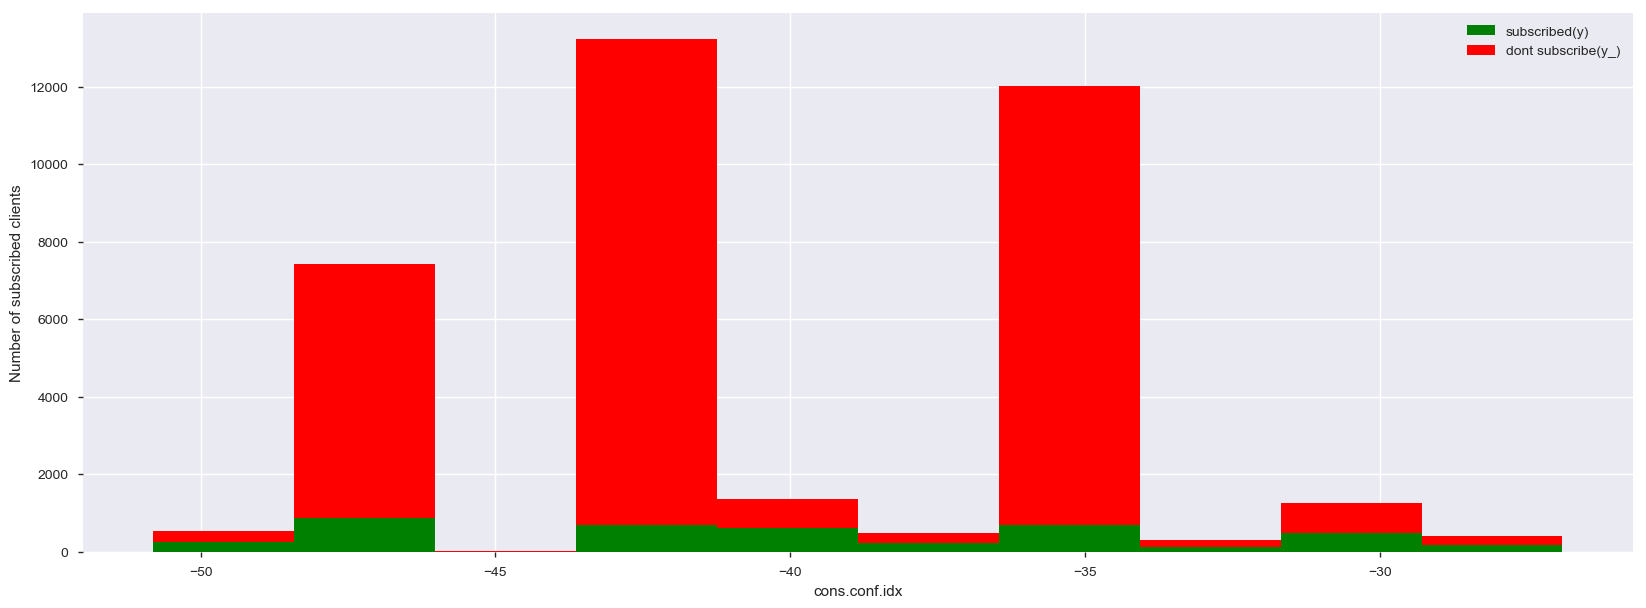

In [153]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['cons.conf.idx'], df[df['y'] == 0]['cons.conf.idx']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('cons.conf.idx')
plt.ylabel('Number of subscribed clients')
plt.legend();

从上面三幅图看不出，三个指数对客户购买是否造成影响

### 2.15 euribor3m

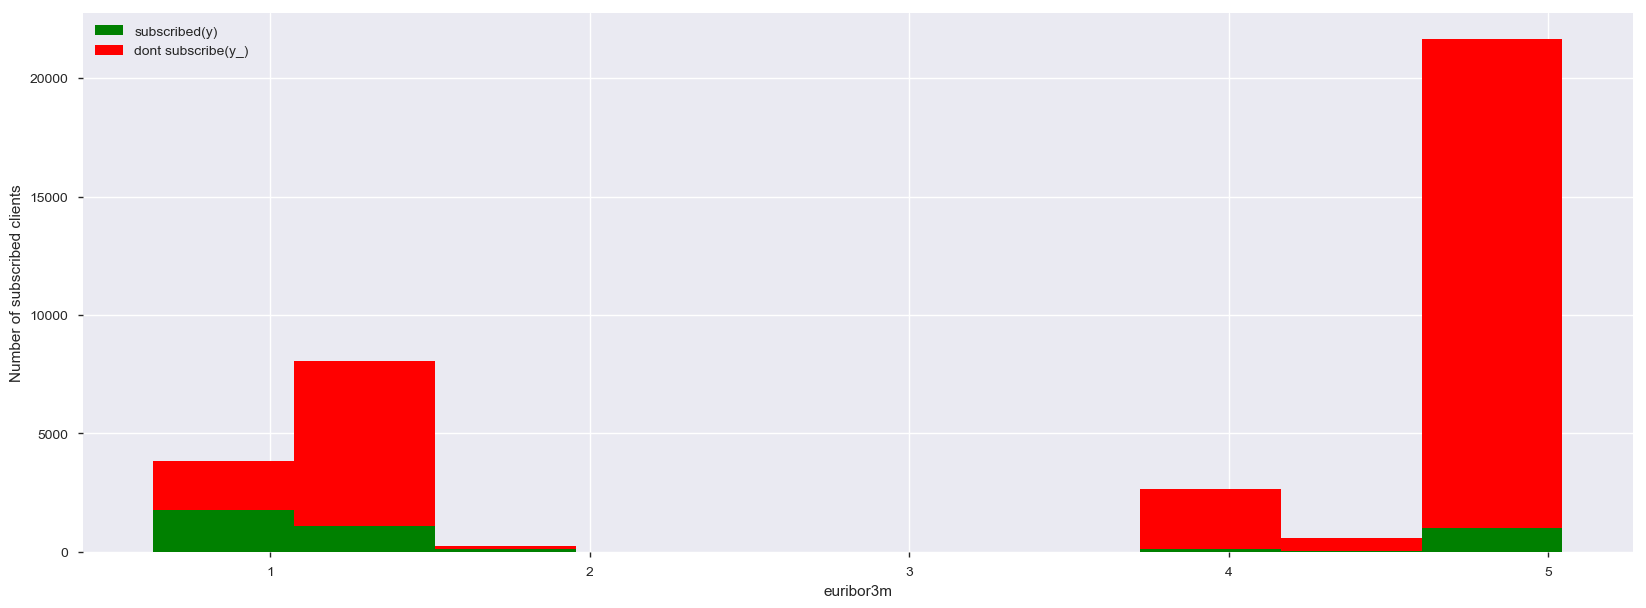

In [154]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['euribor3m'], df[df['y'] == 0]['euribor3m']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('euribor3m')
plt.ylabel('Number of subscribed clients')
plt.legend();

当euribor3m（汇率）比较低时，用户更倾向购买

### 2.16 nr.employed

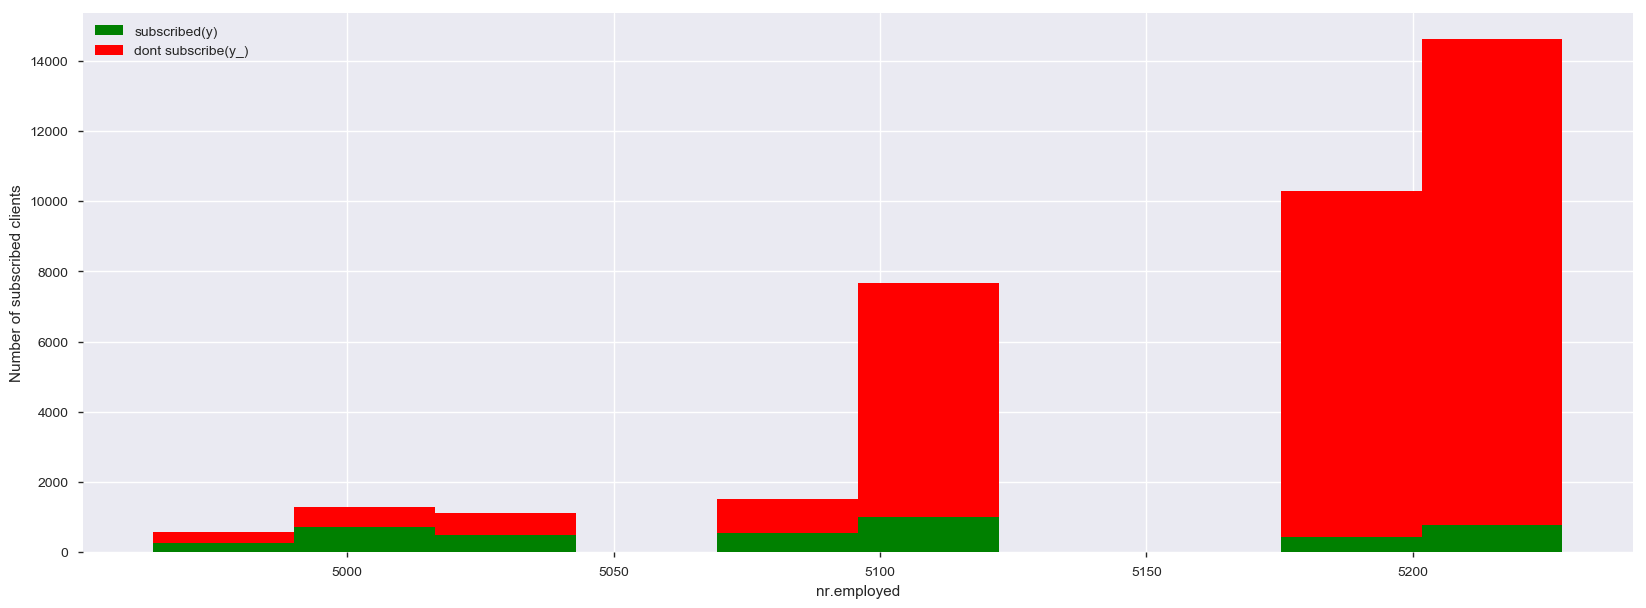

In [155]:
figure = plt.figure(figsize=(20, 7))
plt.hist([df[df['y'] == 1]['nr.employed'], df[df['y'] == 0]['nr.employed']], 
         stacked=True, color = ['g','r'],
         bins = 10, label = ['subscribed(y)','dont subscribe(y_)']) # subscribed
plt.xlabel('nr.employed')
plt.ylabel('Number of subscribed clients')
plt.legend();

## 3 数据预处理

In [103]:
# 数值型数据处理
# 'age', 'balance', 'duration', 'campaign', 'pdays', 'previous'，emp.var.rate，cons.price.idx，cons.conf.idx，euribor3m，nr.employed 
def standardize_nan(x):
    # 标准化
    x_mean = np.nanmean(x)  # 求平均值，但是个数不包括nan
    x_std = np.nanstd(x)
    return (x - x_mean) / x_std
    # 対数変換

## 直方图绘制时分布不均匀的特征
df['log_age'] = np.log(df['age'])
df['log_std_age'] = standardize_nan(df['log_age'])
# df["log_duration"] = np.log(df['duration']+ 1) # duration 字段不能用
df["log_campaign"] = np.log(df['campaign'] + 1)
df["log_pdays"] = np.log(df['pdays'] - df['pdays'].min() + 1)
df['log_previous'] = np.log(df['previous'] + 1)  # 这里没有+1

df['log_emp.var.rate'] = np.log(df['emp.var.rate'] + 1)  # 这里没有+1
df['log_cons.price.idx'] = np.log(df['cons.price.idx'] + 1)  # 这里没有+1
df['log_euribor3m'] = np.log(df['euribor3m'] + 1)  # 这里没有+1
df['log_nr.employed '] = np.log(df['nr.employed'] + 1)  # 这里没有+1


# month 文字列与数値的変換
df['month'] = df['month'].map({'jan': 1,
                               'feb': 2,
                               'mar': 3,
                               'apr': 4,
                               'may': 5,
                               'jun': 6,
                               'jul': 7,
                               'aug': 8,
                               'sep': 9,
                               'oct': 10,
                               'nov': 11,
                               'dec': 12}).astype(int)
# 一周转换
df['day_of_week'] = df['day_of_week'].map({'mon': 1,
                                           'tue': 2,
                                           'wed': 3,
                                           'thu': 4,
                                           'fri': 5, }).astype(int)
# 1月:0、2月:31、3月:(31+28)、4月:(31+28+31)、 ...
day_sum = pd.Series(np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]), index=np.arange(1, 13))
df['date_week1'] = (df['month'].map(day_sum)+df['day_of_week']).astype(int)
df['date_week2'] = (df['month'].map(day_sum)+df['day_of_week']+7).astype(int)
df['date_week3'] = (df['month'].map(day_sum)+df['day_of_week']+14).astype(int)
df['date_week4'] = (df['month'].map(day_sum)+df['day_of_week']+21).astype(int)

# 其他新增
df['total_touch'] = df['previous'] + df['campaign']  # 总联系人数
df['total_touch_log'] = np.log(df['total_touch'])

# 有序特征
lb=LabelEncoder()
marital_map = {"married": 1, "single": 3, "divorced": 2, "unknown": 0}
df['marital_num'] = df['marital'].map(marital_map)
df['education_num']=lb.fit_transform(df['education']) # education 数值化
df['euribor3m_mean']=df['euribor3m']/3 #
# ------------End 数据预处理 类别编码-------------

# ---------- Start 数据预处理 类别型数据------------
# 类别型数据
cate_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month','poutcome']
df = pd.get_dummies(df, columns=cate_cols)
# ------------End 数据预处理 类别编码----------
# df = df.drop(["age", "duration", "campaign", "pdays", "previous"], axis=1)  # duration 字段不能用
# df = df.drop(["emp.var.rate", "cons.price.idx", "euribor3m", "nr.employed"], axis=1)

In [104]:
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_,date_week1,date_week2,date_week3,date_week4,total_touch,total_touch_log,marital_num,education_num,euribor3m_mean,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,poutcome_failure,poutcome_nonexistent,poutcome_success
0,32,565,4,999,0,1.4,93.918,-42.7,4.962,5228.1,0,1,182,189,196,203,4,1.386294,1,5,1.654000,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,41,982,1,999,0,-1.8,93.075,-47.1,1.405,5099.1,0,1,91,98,105,112,1,0.000000,1,3,0.468333,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,32,188,2,999,0,-1.8,92.893,-46.2,1.299,5099.1,0,1,121,128,135,142,2,0.693147,1,6,0.433000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,37,56,3,999,0,1.4,93.918,-42.7,4.968,5228.1,0,1,185,192,199,206,3,1.098612,1,3,1.656000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,38,419,8,999,0,1.4,93.918,-42.7,4.961,5228.1,0,1,183,190,197,204,8,2.079442,2,6,1.653667,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [105]:
df.shape,df.columns

((37069, 74),
 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
        'y_', 'date_week1', 'date_week2', 'date_week3', 'date_week4',
        'total_touch', 'total_touch_log', 'marital_num', 'education_num',
        'euribor3m_mean', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
        'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
        'job_services', 'job_student', 'job_technician', 'job_unemployed',
        'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
        'marital_unknown', 'education_basic.4y', 'education_basic.6y',
        'education_basic.9y', 'education_high.school', 'education_illiterate',
        'education_professional.course', 'education_university.degree',
        'education_unknown', 'default_no', 'default_unknown', 'default_yes',
        'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
        'lo

In [106]:
train_len=18000
# new_train, new_test = df[:train_len], df[train_len:]
# cols = [col for col in df.columns if col not in ['y']]
# X_train,X_test,y_train,y_test=new_train[cols],new_test[cols],new_train['y'],new_test['y']

## 4 建立模型

In [107]:
%matplotlib inline
def plot_fea_importance(classifier,X_train):
    plt.figure(figsize=(10,12))
    name = "xgb"
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],
                    x=classifier.feature_importances_[indices][:40],orient='h')
    g.set_xlabel("Relative importance", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    plt.show()


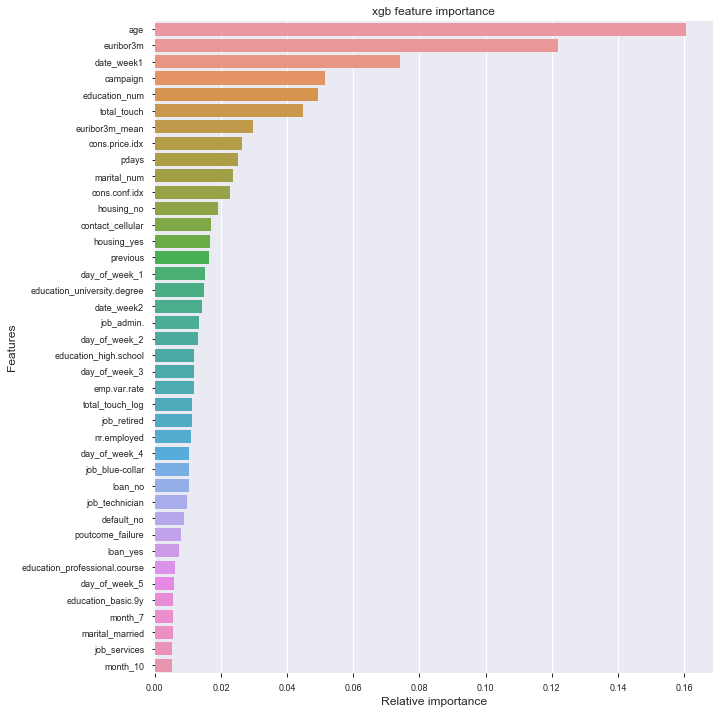

5 Fold auc: 0.7874695404761572
0.8034382742819873
Wall time: 1min 2s


In [110]:
%%time
def evaluate_cv5_lgb(train_df, test_df, cols, test=False):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_test = 0
    oof_train = np.zeros((train_df.shape[0],))
    for i, (train_index, val_index) in enumerate(kf.split(train_df[cols])):
        X_train, y_train = train_df.loc[train_index, cols], train_df.y.values[train_index]
        X_val, y_val = train_df.loc[val_index, cols], train_df.y.values[val_index]
        xgb = XGBClassifier(n_estimators=4000,
                            learning_rate=0.03,
                            num_leaves=30,
                            colsample_bytree=.8,
                            subsample=.9,
                            max_depth=7,
                            reg_alpha=.1,
                            reg_lambda=.1,
                            min_split_gain=.01,
                            min_child_weight=2,
                            verbose=False)
        xgb.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=100, eval_metric=['auc'], verbose=False)
        y_pred = xgb.predict_proba(X_val)[:,1]
        if test:
            y_test += xgb.predict_proba(test_df.loc[:, cols])[:,1]
        oof_train[val_index] = y_pred
        if i==0:
            plot_fea_importance(xgb,X_train)
    gc.collect()
    auc = roc_auc_score(train_df.y.values, oof_train)
    y_test /= 5
    print('5 Fold auc:', auc)
    return y_test

train_len=18000
train,test=df[:train_len], df[train_len:]
cols = [col for col in train.columns if col not in ['id','y','y_','duration']]
y_pred=evaluate_cv5_lgb(train,test,cols,True)
print(roc_auc_score(test.y,y_pred))

In [109]:
# gbm_cv.best_params_